In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("AAPL_train.csv")
train['Date'] = pd.to_datetime(train['Date'])
adj_df = train.set_index('Date')[['Adj Close']]
adj_df.head()

,Adj Close
Date,
2019-01-02,37.845032
2019-01-03,34.075394
2019-01-04,35.530045
2019-01-07,35.450962
2019-01-08,36.126770


In [3]:
#shift adjusted close for the next 50 days
adj_df['Predict'] = adj_df['Adj Close'].shift(-50)
adj_df

,Adj Close,Predict
Date,,
2019-01-02,37.845032,44.794380
2019-01-03,34.075394,45.251656
2019-01-04,35.530045,44.893051
2019-01-07,35.450962,45.285362
2019-01-08,36.126770,46.953232
...,...,...
2024-01-24,194.252121,NaN
2024-01-25,193.922546,NaN
2024-01-26,192.174774,NaN


In [4]:
X_train= np.array(adj_df[['Adj Close']])[:-50]

In [5]:
y_train = np.array(adj_df[['Predict']])[:-50]

In [6]:
test = pd.read_csv('AAPL_test.csv')
test['Date'] = pd.to_datetime(test['Date'])
actual_test = np.array(test[['Adj Close']])

In [7]:
X_test = np.array(adj_df[['Adj Close']])[-50:]

In [8]:
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [9]:
models = {}
models["Linear"] = LinearRegression()
models["Lasso"] = Lasso()
models["Ridge"] = Ridge()
models["ElasticNet"] = ElasticNet()
models["KNN"] = KNeighborsRegressor()
models["DecisionTree"] = DecisionTreeRegressor()
models["SVR"] = SVR(kernel='rbf', C=1e3, gamma='scale')
models["AdaBoost"] = AdaBoostRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["RandomForest"] = RandomForestRegressor()
models["ExtraTrees"]= ExtraTreesRegressor()
models["BaggingRegressor"] = BaggingRegressor()
models["XGBRegressor"] = XGBRegressor(objective ='reg:squarederror')
models["MLPRegressor"] = MLPRegressor(solver = 'lbfgs')

In [10]:
model_results = []  
model_names   = []
for model_name in models:
    model = models[model_name]
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=7)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    model_results.append(cv_results)
    model_names.append(model_name)
    print("{}: {}, ({})".format(model_name, round(cv_results.mean(), 6), round(cv_results.std(), 6)))
     

Linear: -1.755253, (1.22016)
Lasso: -1.827704, (1.313973)
Ridge: -1.755459, (1.220411)
ElasticNet: -1.807407, (1.286157)
KNN: -5.843184, (4.07696)
DecisionTree: -5.958886, (4.054755)
SVR: -5.618493, (3.970893)
AdaBoost: -5.370906, (4.319638)
GradientBoost: -5.629764, (4.132185)
RandomForest: -5.911473, (4.036002)
ExtraTrees: -5.788948, (4.077062)
BaggingRegressor: -5.662064, (4.034162)
XGBRegressor: -5.646513, (4.041461)
MLPRegressor: -2.051395, (1.117596)


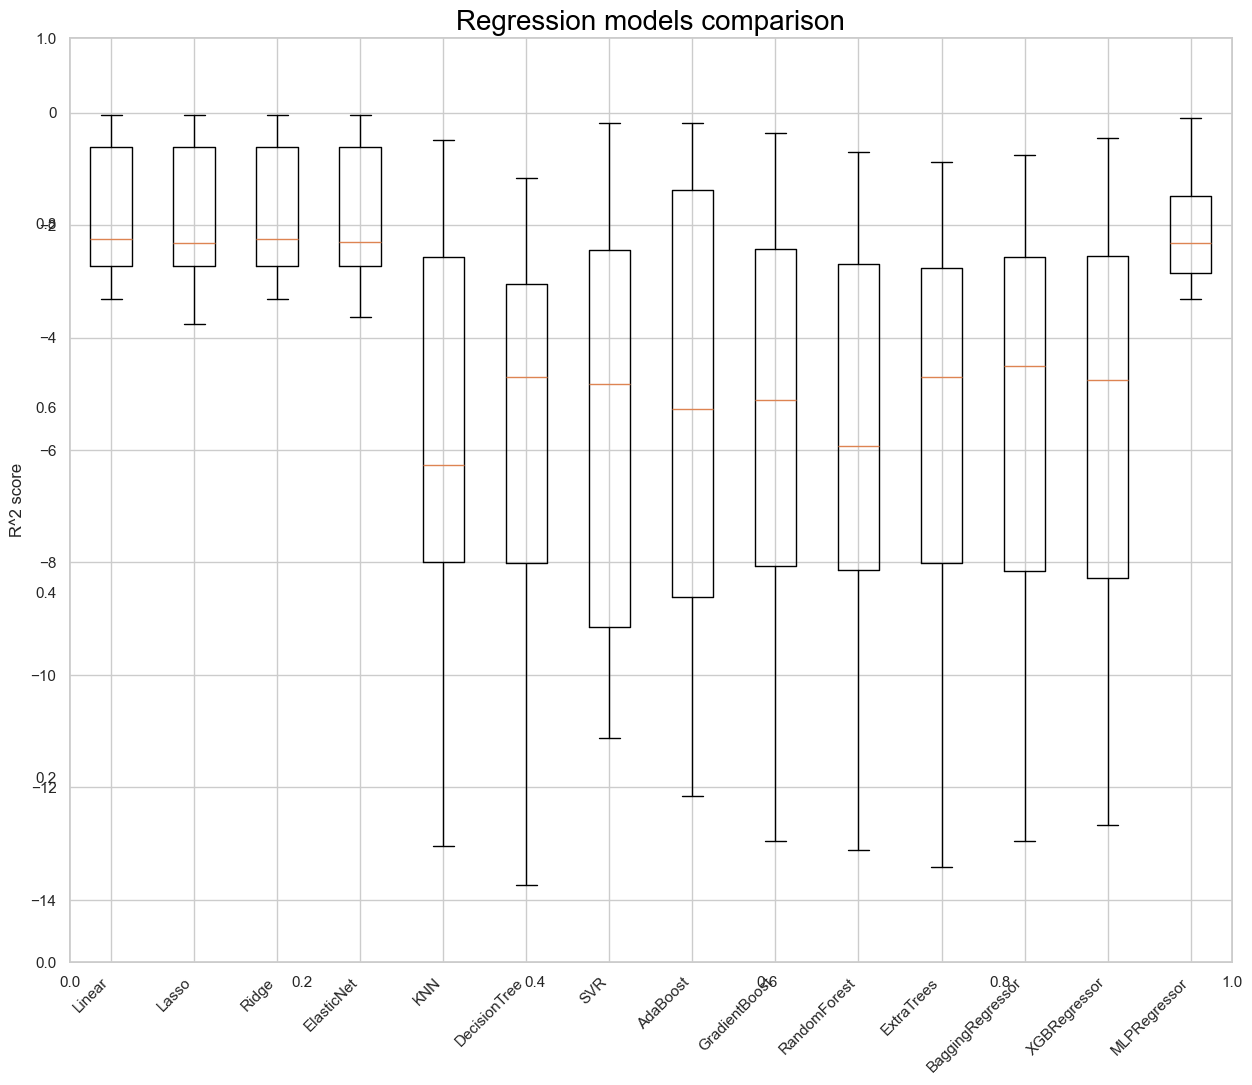

In [11]:
def box_compare():
  sns.set(rc={'figure.figsize':(15, 12)})
  sns.set_style(style='whitegrid', )
  figure = plt.figure()
  plt.title('Regression models comparison', color = 'black', fontsize = 20)
  axis = figure.add_subplot(111)
  plt.boxplot(model_results)
  axis.set_xticklabels(model_names, rotation = 45, ha="right")
  axis.set_ylabel("R^2 score")
  plt.margins(0.05, 0.1)

box_compare()

In [12]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [13]:
pred = lr.predict(X_test)

In [14]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(actual_test, pred, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(actual_test, pred), 3)))

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# report performance
mse = mean_squared_error(actual_test, pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(actual_test, pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(actual_test, pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred - actual_test)/np.abs(actual_test))
print('MAPE: '+str(mape))

Coefficients:  [[0.92854278]]
RMSE: 16.599
R^2 score: -4.791
MSE: 275.5215270060418
MAE: 14.70562182274083
RMSE: 16.598841134429893
MAPE: 0.0846256981618254


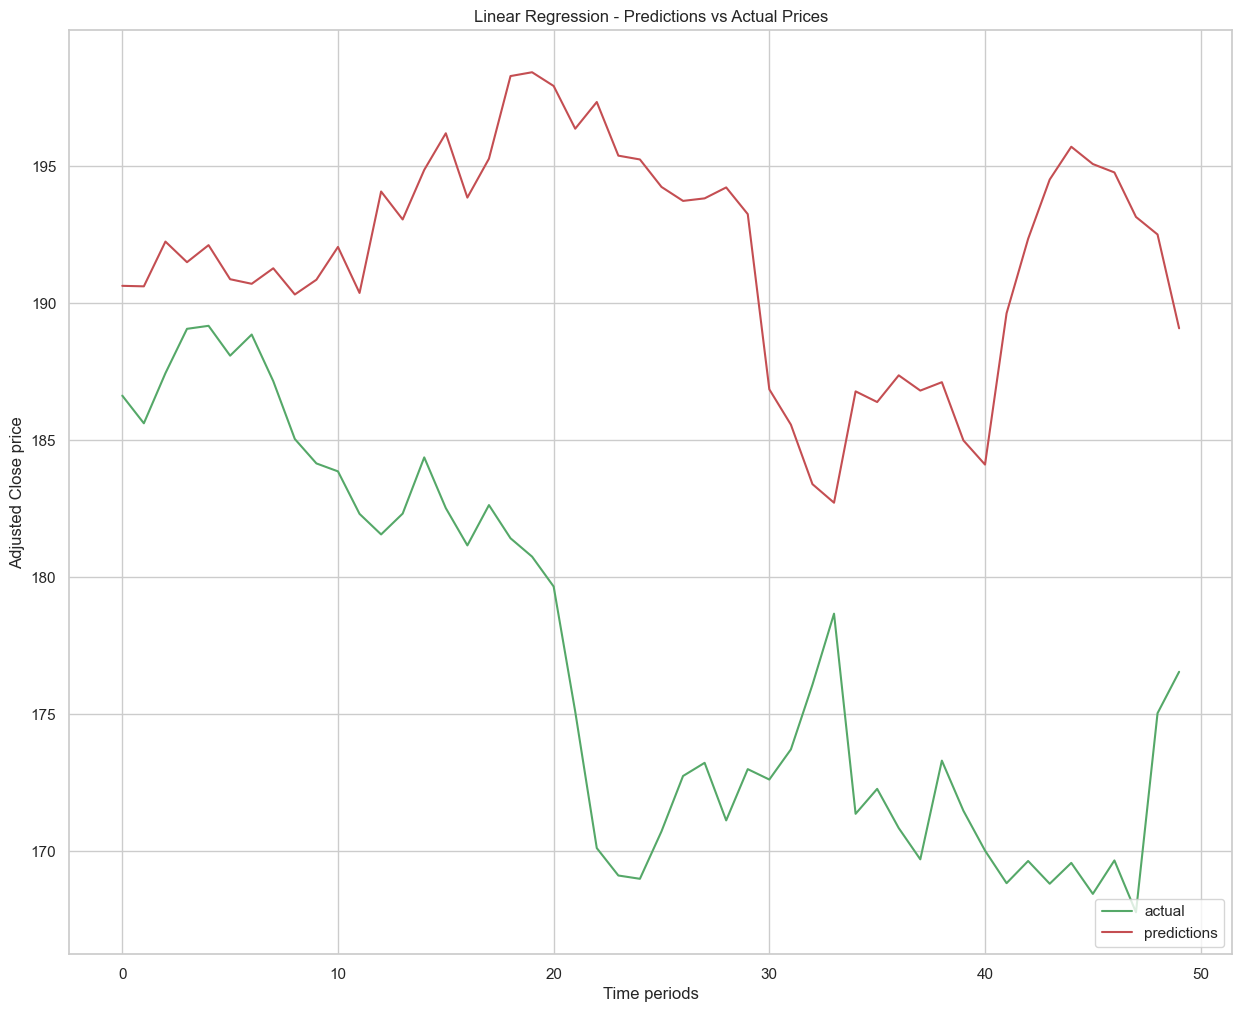

In [15]:
x_axis = np.array(range(0, pred.shape[0]))
plt.plot(x_axis, actual_test, color='g', label="actual")
plt.plot(x_axis, pred, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

In [16]:
pd.DataFrame({"Actual": actual_test.reshape(-1), "Predict": pred.reshape(-1)}).head()

,Actual,Predict
0,186.621872,190.626972
1,185.613159,190.608412
2,187.440811,192.240559
3,189.058762,191.489405
4,189.168625,192.110734


In [17]:
# parameters = {'fit_intercept': [True, False],'copy_X': [True,False], 'positive' : [True,False],
#          'n_jobs': [None, -1]}
# gridsearchcv_lr = GridSearchCV(estimator=lr, param_grid=parameters, cv=tscv, scoring='r2')
# grid_result_lr = gridsearchcv_lr.fit(X_train, y_train)
# print("Best: {} using {}".format(grid_result_lr.best_score_, grid_result_lr.best_params_))
# best_model_lr = grid_result_lr.best_estimator_
# print(f"Best model has the following hyperparameters: {best_model_lr}")

In [18]:
lr = LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,positive=False)

# Train the model using the training sets
lr.fit(X_train, y_train)

# Make predictions using the model
predictions = lr.predict(actual_test)


# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(actual_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(actual_test, predictions), 3)))
     
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# report performance
mse = mean_squared_error(actual_test, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(actual_test, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(actual_test, predictions))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions - actual_test)/np.abs(actual_test))
print('MAPE: '+str(mape))

Coefficients:  [[1.03558301]]
RMSE: 6.305
R^2 score: 0.164
MSE: 39.74909326735895
MAE: 6.299909370860883
RMSE: 6.304688197473286
MAPE: 0.03558300551482938


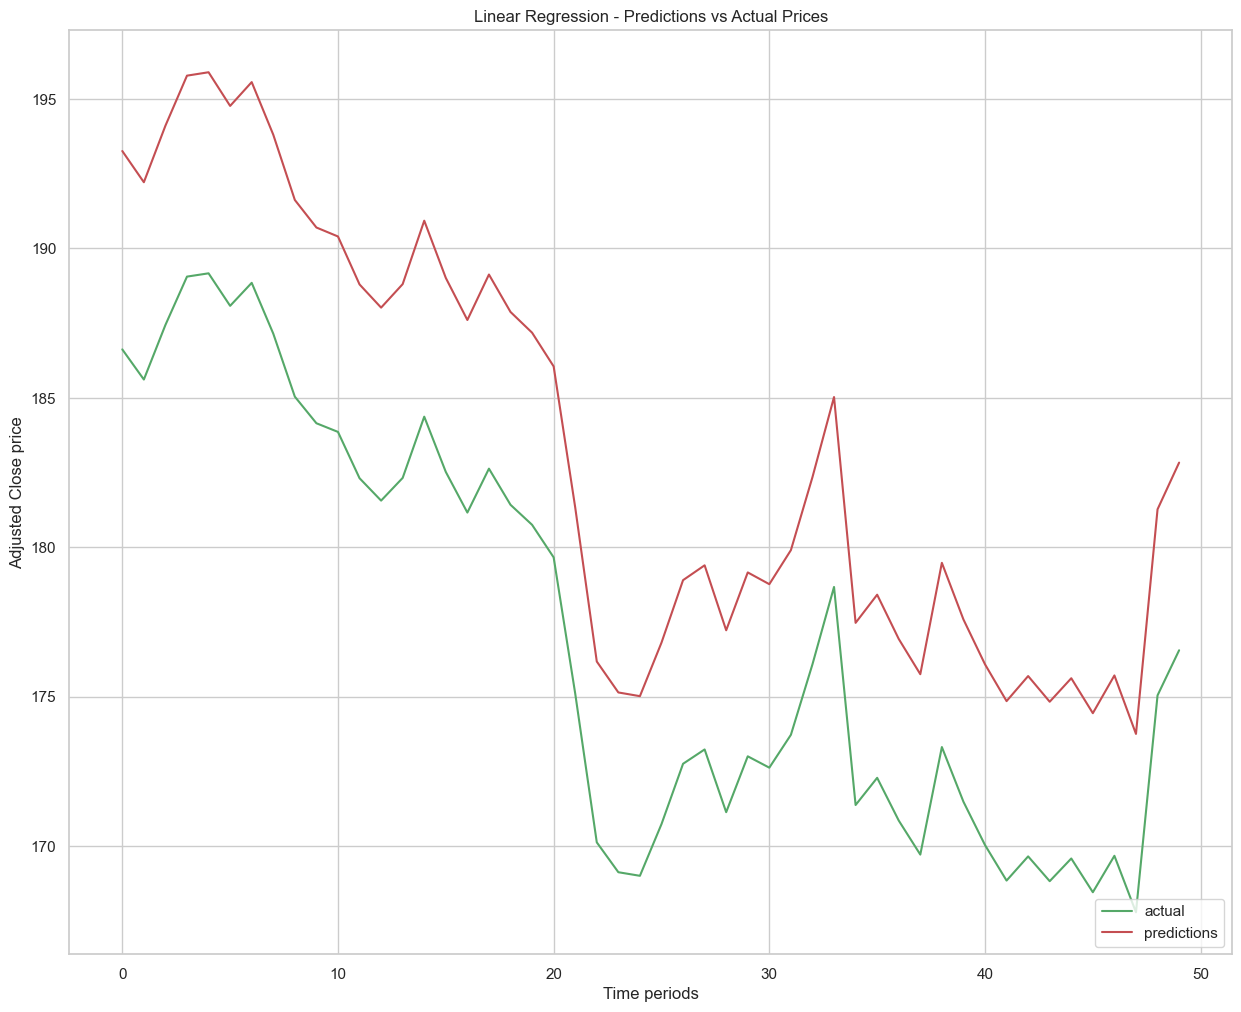

In [19]:
x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, actual_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

In [20]:
mlpr = MLPRegressor(max_iter=500, solver = 'lbfgs')

# Train the model using the training sets
mlpr.fit(X_train, y_train)
mlpr

MLPRegressor(max_iter=500, solver='lbfgs')

In [21]:
predictions = mlpr.predict(X_test)

In [22]:
print('RMSE: {}'.format(round(mean_squared_error(actual_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(actual_test, predictions), 3)))

mse = mean_squared_error(actual_test, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(actual_test, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(actual_test, predictions))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions - actual_test)/np.abs(actual_test))
print('MAPE: '+str(mape))

RMSE: 10.927
R^2 score: -1.51
MSE: 119.39217465213292
MAE: 9.108309500430984
RMSE: 10.926672624918023
MAPE: 0.05370965446295144


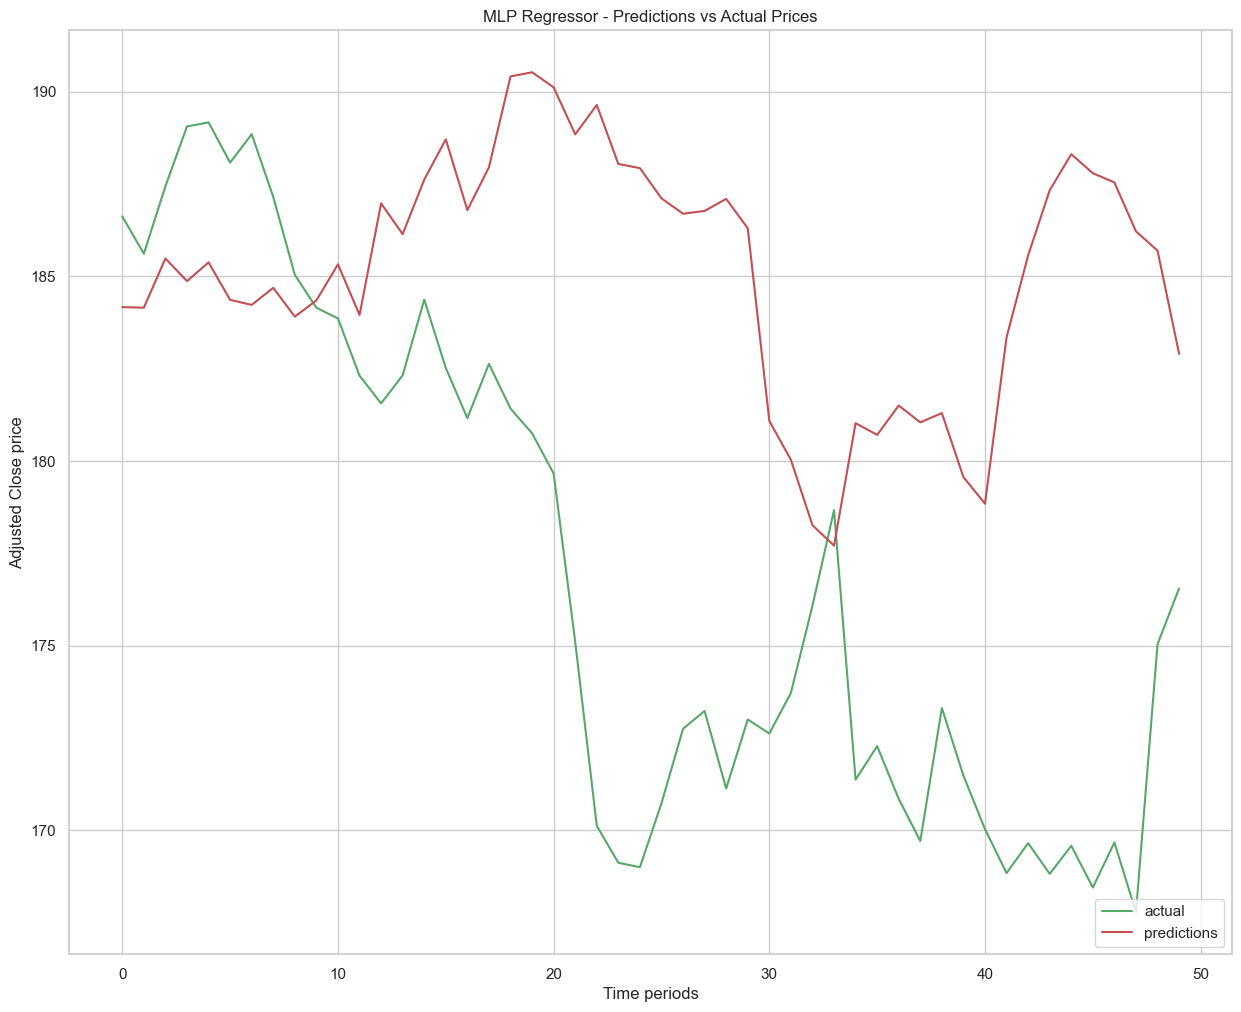

In [23]:
x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, actual_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()
     

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)
y_train_norm = scaler.transform(y_train)
X_test_norm = scaler.transform(X_test)

# mlpr = MLPRegressor(max_iter=500)
# parameters = {"hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)],
#               "activation": ["identity", "logistic", "tanh", "relu"], 
#               "solver": ["lbfgs", "sgd", "adam"], 
#               "alpha": [0.0001, 0.05], 
#               "learning_rate": ['constant','adaptive']}
# gridsearchcv_mlpr = GridSearchCV(estimator=mlpr, param_grid=parameters, cv=tscv, scoring='r2')
# grid_result_mlpr = gridsearchcv_mlpr.fit(X_train_norm, y_train_norm)
# print("Best: {} using {}".format(grid_result_mlpr.best_score_, grid_result_mlpr.best_params_))

In [25]:
# mlpr = MLPRegressor(max_iter=500)
# parameters = {"hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)],
#               "activation": ["identity", "logistic", "tanh", "relu"], 
#               "solver": ["lbfgs", "sgd", "adam"], 
#               "alpha": [0.0001, 0.05], 
#               "learning_rate": ['constant','adaptive']}
# gridsearchcv_mlpr = GridSearchCV(estimator=mlpr, param_grid=parameters, cv=tscv, scoring='r2')
# grid_result_mlpr = gridsearchcv_mlpr.fit(X_train_norm, y_train_norm)
# print("Best: {} using {}".format(grid_result_mlpr.best_score_, grid_result_mlpr.best_params_))



In [26]:
mlpr = MLPRegressor(activation='identity', alpha=0.05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

mlpr.fit(X_train, y_train)

# Make predictions using the model
predictions = mlpr.predict(actual_test)

# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(actual_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(actual_test, predictions), 3)))

     

RMSE: 7.676
R^2 score: -0.239


MSE: 58.92761853488549
MAE: 7.671665505894087
RMSE: 7.676432669859451
MAPE: 0.05954106146053004


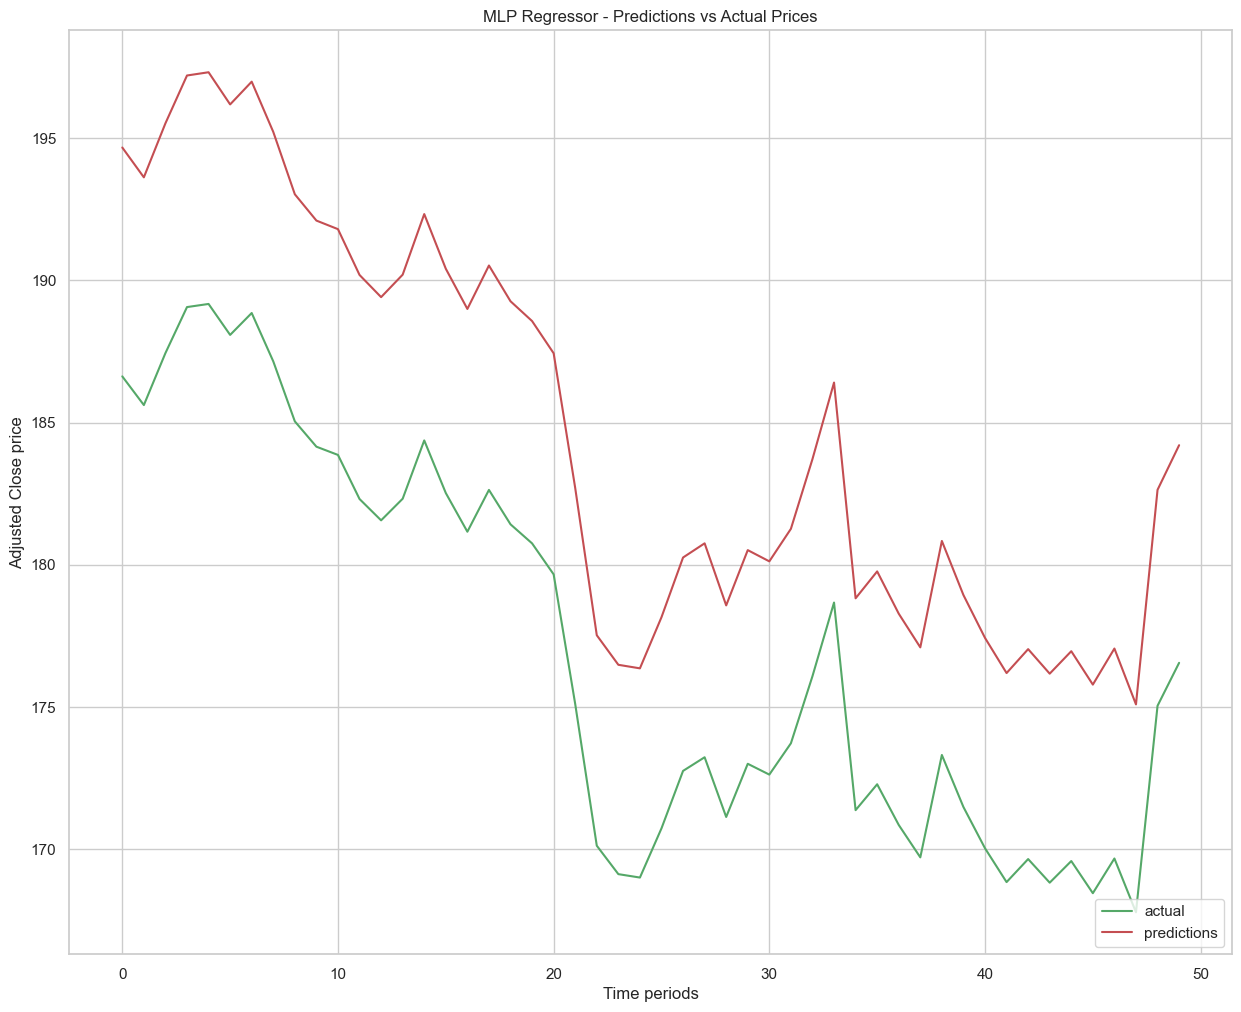

In [27]:
mse = mean_squared_error(actual_test, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(actual_test, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(actual_test, predictions))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions - actual_test)/np.abs(actual_test))
print('MAPE: '+str(mape))

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, actual_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

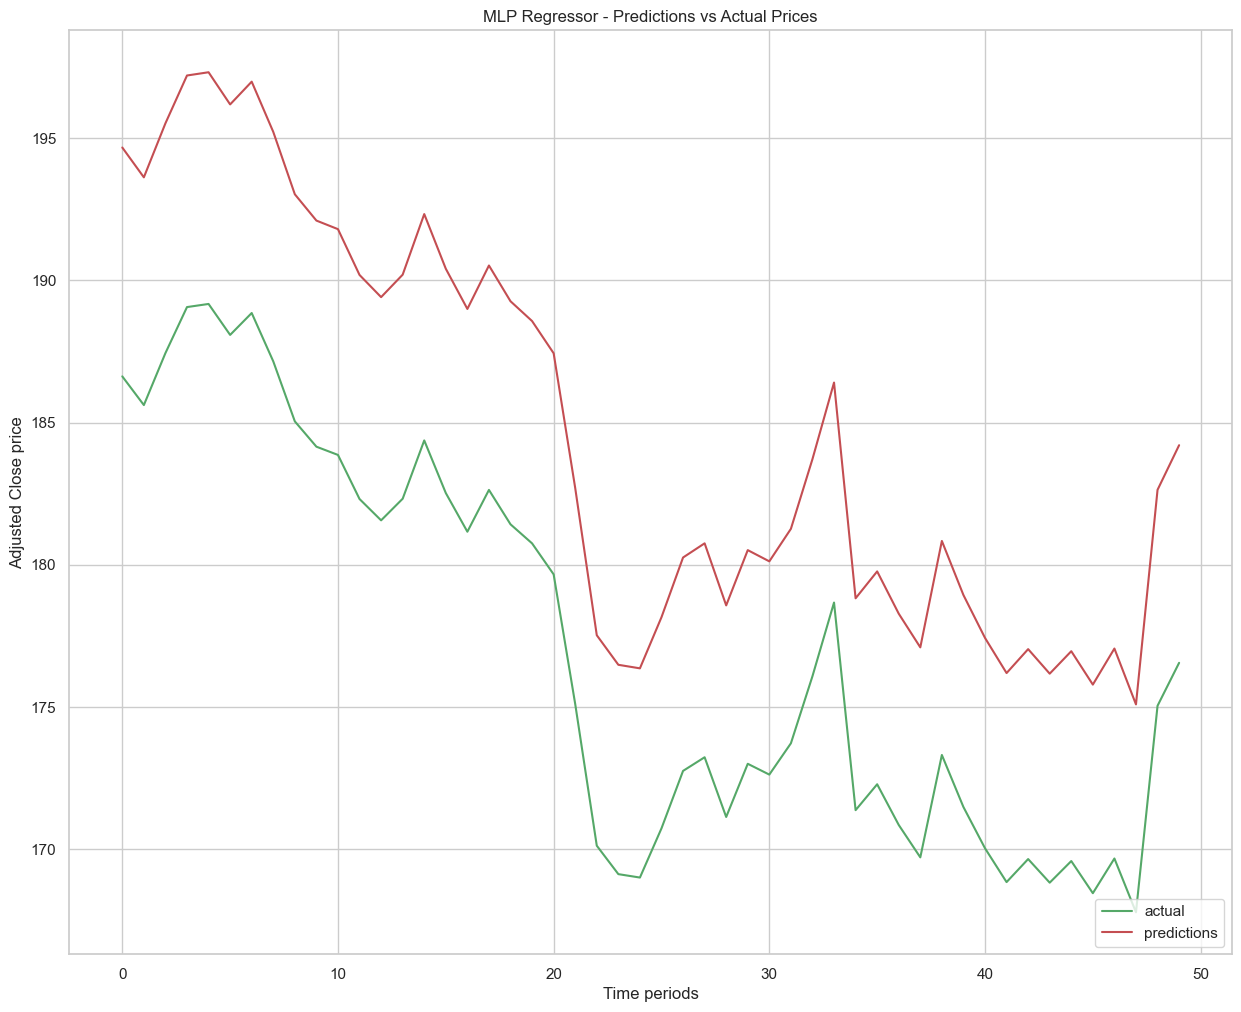

In [28]:
x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, actual_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Another approach

In [29]:
og_adj_df = adj_df.drop('Predict',axis=1)

In [30]:
merge = pd.concat([train,test],axis = 0, ignore_index=True)
full_adj = merge.set_index('Date')[['Adj Close']]

In [31]:
def shift_back(df,n_day,col):
    for i in range(1,n_day+1):
        df[f'P(t-{i})'] = df[col].shift(i)
    return df

In [32]:
shift_3 = shift_back(full_adj,3,'Adj Close')

In [33]:
shift_train = shift_3[:train.shape[0]].dropna()
shift_test = shift_3[train.shape[0]:]

In [34]:
# X_train = shift_train[['P(t-1)','P(t-2)','P(t-3)']]
# X_test = shift_test[['P(t-1)','P(t-2)','P(t-3)']]
# y_train = shift_train['Adj Close']
X_train = shift_train.drop('Adj Close',axis = 1)
X_test = shift_test.drop('Adj Close', axis = 1)
y_train = shift_train['Adj Close']

Linear: 0.939161, (0.028613)
Lasso: 0.934129, (0.029284)
Ridge: 0.939176, (0.028618)
ElasticNet: 0.934847, (0.02856)
KNN: -0.552702, (1.254162)
DecisionTree: -0.836327, (1.474659)
SVR: -2.431657, (3.312339)
AdaBoost: -0.739133, (1.334502)
GradientBoost: -0.666665, (1.258817)
RandomForest: -0.609597, (1.337177)
ExtraTrees: -0.707651, (1.380988)
BaggingRegressor: -0.613516, (1.285624)
XGBRegressor: -0.90875, (1.423888)
MLPRegressor: 0.938753, (0.028975)


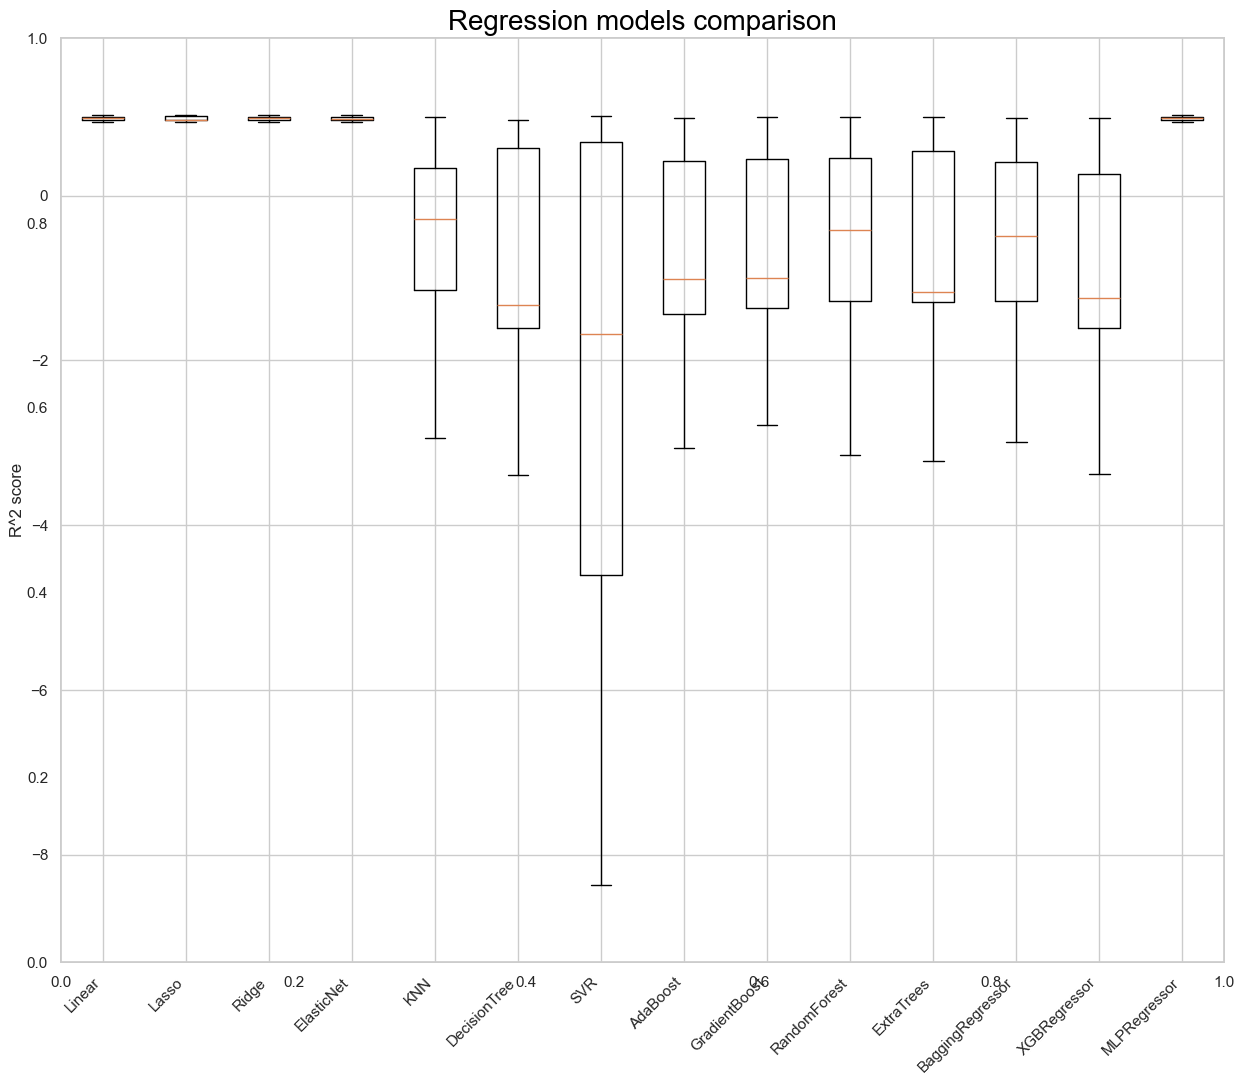

In [35]:
model_results = []  
model_names   = []
for model_name in models:
    model = models[model_name]
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=7)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    model_results.append(cv_results)
    model_names.append(model_name)
    print("{}: {}, ({})".format(model_name, round(cv_results.mean(), 6), round(cv_results.std(), 6)))

def box_compare():
  sns.set(rc={'figure.figsize':(15, 12)})
  sns.set_style(style='whitegrid', )
  figure = plt.figure()
  plt.title('Regression models comparison', color = 'black', fontsize = 20)
  axis = figure.add_subplot(111)
  plt.boxplot(model_results)
  axis.set_xticklabels(model_names, rotation = 45, ha="right")
  axis.set_ylabel("R^2 score")
  plt.margins(0.05, 0.1)

box_compare()

In [36]:
lr1 = LinearRegression()
lr1.fit(X_train,y_train)
pred2 = lr1.predict(X_test)

In [37]:
true_y = shift_test['Adj Close'].values

RMSE: 2.254
R^2 score: 0.893


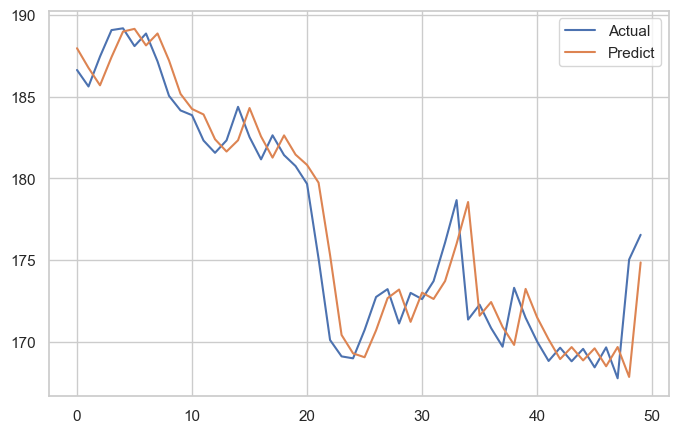

In [38]:
plt.figure(figsize=(8,5))
plt.plot(true_y,label = "Actual")
plt.plot(pred2, label = "Predict")
plt.legend()
print('RMSE: {}'.format(round(mean_squared_error(true_y, pred2, squared=False), 3)))
print('R^2 score: {}'.format(round(r2_score(true_y, pred2), 3)))


In [39]:
mse = mean_squared_error(true_y, pred2)
print('MSE: '+str(mse))
mae = mean_absolute_error(true_y, pred2)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(true_y, pred2))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred2 - true_y)/np.abs(true_y))
print('MAPE: '+str(mape))

MSE: 5.0802938918271545
MAE: 1.7195033805368962
RMSE: 2.253950729680477
MAPE: 0.009778782349746726


In [40]:
parameters = {'fit_intercept': [True, False],'copy_X': [True,False], 'positive' : [True,False],
         'n_jobs': [None, -1]}
gridsearchcv_lr = GridSearchCV(estimator=lr, param_grid=parameters, cv=tscv, scoring='r2')
grid_result_lr = gridsearchcv_lr.fit(X_train, y_train)
print("Best: {} using {}".format(grid_result_lr.best_score_, grid_result_lr.best_params_))
best_model_lr = grid_result_lr.best_estimator_
print(f"Best model has the following hyperparameters: {best_model_lr}")

Best: 0.9396301483860946 using {'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'positive': True}
Best model has the following hyperparameters: LinearRegression(fit_intercept=False, positive=True)


RMSE: 2.271
R^2 score: 0.892
MSE: 5.155752175400583
MAE: 1.7370192185884015
RMSE: 2.2706281455580926
MAPE: 0.009878435454888968


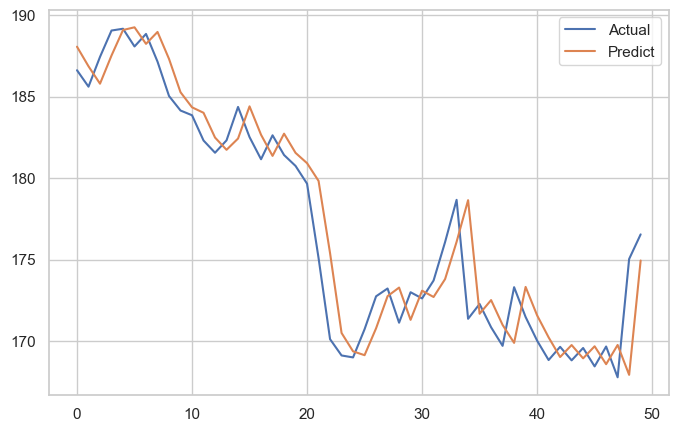

In [41]:
better_lr = LinearRegression(copy_X=True, fit_intercept=False,n_jobs=None,positive=True)
better_lr.fit(X_train,y_train)
pred3 = better_lr.predict(X_test)
plt.figure(figsize=(8,5))
plt.plot(true_y,label = "Actual")
plt.plot(pred3, label = "Predict")
plt.legend()
print('RMSE: {}'.format(round(mean_squared_error(true_y, pred3, squared=False), 3)))
print('R^2 score: {}'.format(round(r2_score(true_y, pred3), 3)))
mse = mean_squared_error(true_y, pred3)
print('MSE: '+str(mse))
mae = mean_absolute_error(true_y, pred3)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(true_y, pred3))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred3 - true_y)/np.abs(true_y))
print('MAPE: '+str(mape))

In [42]:
mse = mean_squared_error(true_y, pred3)
print('MSE: '+str(mse))
mae = mean_absolute_error(true_y, pred3)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(true_y, pred3))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred3 - true_y)/np.abs(true_y))
print('MAPE: '+str(mape))

MSE: 5.155752175400583
MAE: 1.7370192185884015
RMSE: 2.2706281455580926
MAPE: 0.009878435454888968


In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

class ML_shift:
    def __init__(self, data, train_size=1278, col='Adj Close'):
        self.data = data
        self.train_size = train_size
        self.col = col
        #self.n_days = 0
        #self.X_train, self.y_train, self.X_test, self.y_test = self.train_test(n_days)
        
    def shift_back(self, n_days, col):
        temp = self.filter()
        for i in range(1, n_days+1):
            temp[f'P(t-{i})'] = temp[col].shift(i)
        return temp
    
    def filter(self):
        filter = self.data.copy()
        filter['Date'] = pd.to_datetime(filter['Date'])
        filter = filter.set_index('Date')[[self.col]]
        return filter

    def train_test(self,n_days):
        shifted = self.shift_back(n_days = n_days, col =self.col)
        train = shifted[:self.train_size].dropna()
        test = shifted[self.train_size:]
        X_train = train.drop(self.col, axis=1)
        y_train = train[self.col].values
        X_test = test.drop(self.col, axis=1)
        y_test = test[self.col].values
        return X_train, y_train, X_test, y_test
    
    def model_fit(self):
        model = LinearRegression()
        model.fit(self.X_train, self.y_train)
        pred = model.predict(self.X_test)
        rmse = mean_squared_error(self.y_test, pred, squared=False)
        r2 = r2_score(self.y_test, pred)
        return pred, rmse, r2
    
    def plot(self):
        pred, _, _ = self.model_fit()
        plt.figure(figsize=(10, 5))
        plt.plot(self.y_test, label="Actual")
        plt.plot(pred, label="Predicted")
        plt.legend()
        plt.show()
    
    def fit(self, plot=True,n_days = 3):
        #self.n_days = n_days
        self.X_train, self.y_train, self.X_test, self.y_test = self.train_test(n_days)
        _, rmse, r2 = self.model_fit()
        result = pd.DataFrame(columns = ['Days shifted','RMSE', 'R^2'])
        result_len = len(result)
        result.loc[result_len] = n_days,rmse,r2
        #print(f'RMSE: {rmse}, R^2 : {r2}')
        if plot:
            self.plot()
        return result

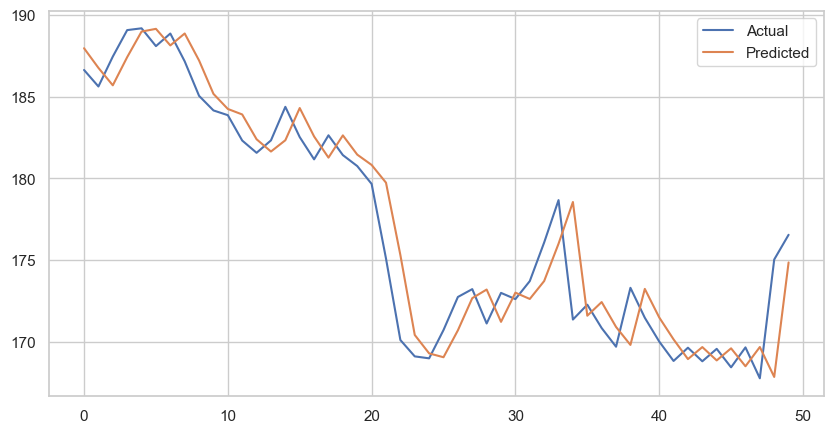

,Days shifted,RMSE,R^2
0,3.0,2.253951,0.893212


In [44]:
check = ML_shift(merge)
check.fit()

In [45]:
check = ML_shift(merge)
df = pd.DataFrame(columns = ['Days shifted','RMSE', 'R^2'])
for i in [1,3,5,7,15,30,200,360,1000]:
    re = check.fit(plot = False, n_days = i)
    df = pd.concat([df,re],ignore_index=True)
    #df.loc[len(df)] = re
df

,Days shifted,RMSE,R^2
0,1.0,2.247111,0.893859
1,3.0,2.253951,0.893212
2,5.0,2.251204,0.893472
3,7.0,2.272100,0.891485
4,15.0,2.291687,0.889606
5,30.0,2.265277,0.892136
6,200.0,2.336869,0.885210
7,360.0,2.992793,0.811727
8,1000.0,13.848015,-3.030975


<Axes: title={'center': 'Number of previous days used'}, xlabel='Days shifted'>

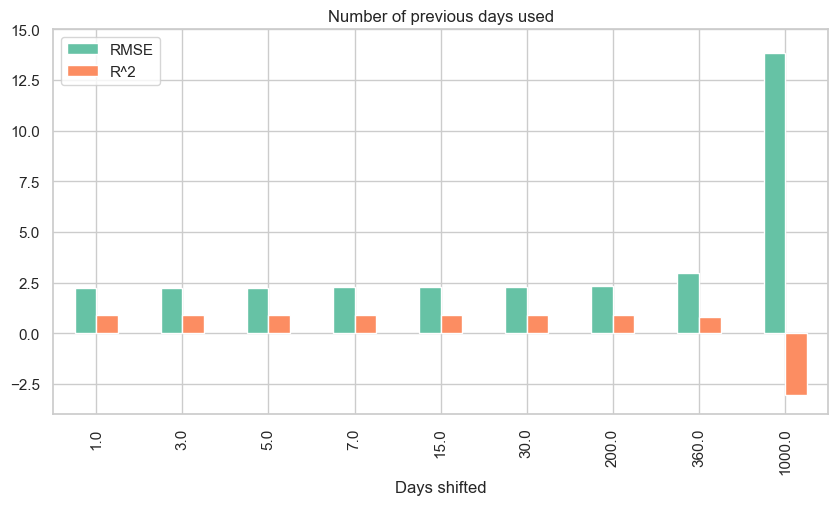

In [46]:
import seaborn as sns
# sns.barplot(data = df,x = 'Days shifted', y = 'RMSE')
sns.set_palette("Set2")
df.plot(x="Days shifted", y=["RMSE", "R^2"], kind="bar", figsize=(10,5),title='Number of previous days used',ylim=(-4, 15)) 

In [47]:
mlpr_shift = MLPRegressor(max_iter=500, solver = 'lbfgs')

# Train the model using the training sets
mlpr_shift.fit(X_train, y_train)
mlpr_shift

MLPRegressor(max_iter=500, solver='lbfgs')

In [48]:
predd = mlpr_shift.predict(X_test)

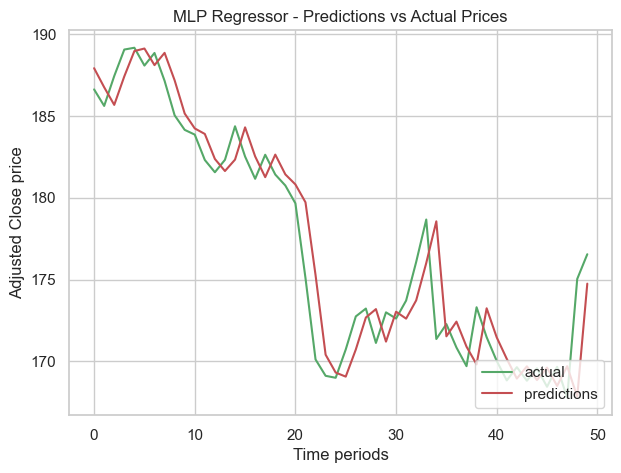

In [49]:
x_axis = np.array(range(0, predd.shape[0]))
plt.figure(figsize=(7,5))
plt.plot(x_axis, true_y, color='g', label="actual")
plt.plot(x_axis, predd, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

In [50]:
#print('RMSE: {}'.format(round(mean_squared_error(true_y, pred3, squared=False), 3)))
print('R^2 score: {}'.format(round(r2_score(true_y, predd), 3)))
mse = mean_squared_error(true_y, predd)
print('MSE: '+str(mse))
mae = mean_absolute_error(true_y, predd)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(true_y, predd))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predd - true_y)/np.abs(true_y))
print('MAPE: '+str(mape))

R^2 score: 0.893
MSE: 5.080152100615692
MAE: 1.720668948222771
RMSE: 2.253919275532221
MAPE: 0.009786079223948065


In [51]:
yy_train = y_train.values

In [52]:
X_train.shape

(1275, 3)

In [53]:
yy_train.reshape(-1,1).shape

(1275, 1)

In [54]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train_norm = scaler.fit_transform(X_train.values)
# y_train_norm = scaler.transform(yy_train.reshape(-1,1))
# X_test_norm = scaler.transform(X_test)

# mlpr = MLPRegressor(max_iter=500)
# parameters = {"hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)],
#               "activation": ["identity", "logistic", "tanh", "relu"], 
#               "solver": ["lbfgs", "sgd", "adam"], 
#               "alpha": [0.0001, 0.05], 
#               "learning_rate": ['constant','adaptive']}
# gridsearchcv_mlpr = GridSearchCV(estimator=mlpr, param_grid=parameters, cv=tscv, scoring='r2')
# grid_result_mlpr = gridsearchcv_mlpr.fit(X_train, y_train)
# print("Best: {} using {}".format(grid_result_mlpr.best_score_, grid_result_mlpr.best_params_))

In [55]:
best_mlp = MLPRegressor(activation = 'relu', alpha = 0.0001, hidden_layer_sizes= (50, 50, 50), learning_rate= 'constant', solver = 'lbfgs')
best_mlp.fit(X_train,y_train)
new_pred = best_mlp.predict(X_test)

MSE: 5.080856074149525
MAE: 1.721425447514315
RMSE: 2.254075436659014
MAPE: 0.009789876278138529
R^2: 0.8931998430861239


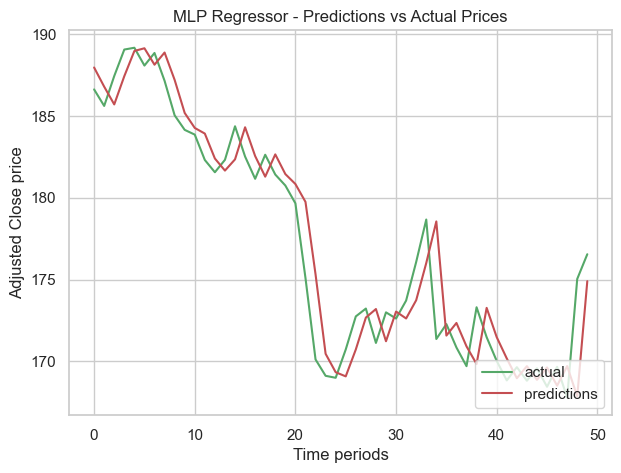

In [56]:
mse = mean_squared_error(true_y, new_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(true_y, new_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(true_y, new_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(new_pred - true_y)/np.abs(true_y))
print('MAPE: '+str(mape))
print(f'R^2: {r2_score(true_y,new_pred)}')

x_axis = np.array(range(0, predd.shape[0]))
plt.figure(figsize=(7,5))
plt.plot(x_axis, true_y, color='g', label="actual")
plt.plot(x_axis, new_pred, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()